In [280]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans

from collections import Counter
from sklearn.cluster import KMeans

In [281]:
sensNames = [
        'T_xacc', 'T_yacc', 'T_zacc',
        'T_xgyro','T_ygyro','T_zgyro',
        'T_xmag', 'T_ymag', 'T_zmag',
        'RA_xacc', 'RA_yacc', 'RA_zacc',
        'RA_xgyro','RA_ygyro','RA_zgyro',
        'RA_xmag', 'RA_ymag', 'RA_zmag',
        'LA_xacc', 'LA_yacc', 'LA_zacc',
        'LA_xgyro','LA_ygyro','LA_zgyro',
        'LA_xmag', 'LA_ymag', 'LA_zmag',
        'RL_xacc', 'RL_yacc', 'RL_zacc',
        'RL_xgyro','RL_ygyro','RL_zgyro',
        'RL_xmag', 'RL_ymag', 'RL_zmag',
        'LL_xacc', 'LL_yacc', 'LL_zacc',
        'LL_xgyro','LL_ygyro','LL_zgyro',
        'LL_xmag', 'LL_ymag', 'LL_zmag'
]


actNames = [
    'sitting',  # 1
    'standing', # 2
    'lying on back',# 3
    'lying on right side', # 4
    'ascending stairs' , # 5
    'descending stairs', # 6
    'standing in an elevator still', # 7
    'moving around in an elevator', # 8
    'walking in a parking lot', # 9
    'walking on a treadmill with a speed of 4 km/h in flat', # 10
    'walking on a treadmill with a speed of 4 km/h in 15 deg inclined position', # 11
    'running on a treadmill with a speed of 8 km/h', # 12
    'exercising on a stepper', # 13
    'exercising on a cross trainer', # 14
    'cycling on an exercise bike in horizontal positions', # 15
    'cycling on an exercise bike in vertical positions', # 16
    'rowing', # 17
    'jumping', # 18
    'playing basketball' # 19
]

actNamesShort = [
    'sitting',  # 1
    'standing', # 2
    'lying.ba', # 3
    'lying.ri', # 4
    'asc.sta' , # 5
    'desc.sta', # 6
    'stand.elev', # 7
    'mov.elev', # 8
    'walk.park', # 9
    'walk.4.fl', # 10
    'walk.4.15', # 11
    'run.8', # 12
    'exer.step', # 13
    'exer.train', # 14
    'cycl.hor', # 15
    'cycl.ver', # 16
    'rowing', # 17
    'jumping', # 18
    'play.bb' # 19
]

act_numbers = [x+1 for x in range(len(actNames))]
activity_names_short_dict = dict(zip(actNames, actNamesShort))

In [282]:
def generateDF(filedir,colnames,sensors,patients,activities,slices):
    # get the data from files for the selected patients
    # and selected activities
    # concatenate all the slices
    # generate a pandas dataframe with an added column: activity
    x=pd.DataFrame()
    for pat in patients:
        for a in activities:
            subdir='a'+f"{a:02d}"+'/p'+str(pat)+'/'
            for s in slices:
                filename=filedir+subdir+'s'+f"{s:02d}"+'.txt'
                #print(filename)
                x1=pd.read_csv(filename,usecols=sensors,names=colnames)
                x1['activity']=a*np.ones((x1.shape[0],),dtype=int)
                x=pd.concat([x,x1], axis=0, join='outer', ignore_index=True,
                            keys=None, levels=None, names=None, verify_integrity=False,
                            sort=False, copy=True)
    return x

In [283]:
def genFeatures(x,N):
    # the input is the output of generateDF (including the activity name)
    act=act = x['activity'].iloc[0]  # Use iloc to access the first row regardless of index
    y=x.drop(columns=['activity'])
    cols0=y.columns
    cols1=cols0+'_mean'
    cols2=cols0+'_std'
    y=y.values # get the values of dataFrame x
    Nin=y.shape[0]# number of points in the input dataframe
    Nout=Nin-N # number of valid points in the output dataframe
    yav_m=np.zeros((Nin,y.shape[1]))
    yav_std=np.zeros((Nin,y.shape[1]))
    for k in range(Nout):
        temp=y[k:k+N,:]# get the k-th window with N samples
        yav_m[k+N,:]=np.mean(temp,0)
        yav_std[k+N,:]=np.std(temp,0)
    yav_m=yav_m[N:,:]
    yav_std=yav_std[N:,:]
    outm_df=pd.DataFrame(yav_m,columns=cols1)
    outs_df=pd.DataFrame(yav_std,columns=cols2)
    out_a=pd.DataFrame(act*np.ones((Nout,1)),columns=['activity'])
    out_df=pd.concat([outm_df,outs_df,out_a],axis=1)
    return out_df

In [284]:
filedir='data/'

In [285]:
patients=[5]  # list of selected patients
NAc=19 # total number of activities
activities=list(range(1,20)) #list of indexes of activities to plot
Num_activities=len(activities)
actNamesSub=[actNamesShort[i-1] for i in activities] # short names of the selected activities

ind_acc = [i for i in range(45) if 'acc' in sensNames[i]]# accelerometers
ind_mag = [i for i in range(45) if 'mag' in sensNames[i]]# magnetometers
ind_gyr = [i for i in range(45) if 'gyr' in sensNames[i]]# gyroscopes
sensors1=ind_acc+ind_mag+ind_gyr
sensorsT = [i for i in sensors1 if 'T' in sensNames[i]] # sensors on torso
sensorsLL = [i for i in sensors1 if 'LL' in sensNames[i]]# sensors on left leg
sensorsLA = [i for i in sensors1 if 'LA' in sensNames[i]]# sensors on left arm
sensorsRL = [i for i in sensors1 if 'RL' in sensNames[i]]# sensors on right leg
sensorsRA = [i for i in sensors1 if 'RA' in sensNames[i]]# sensors on right arm
sensors=sensorsT#+sensorsRA+sensorsLL # selected sensors

sensNamesSub=[sensNames[i] for i in sensors] # names of selected sensors
Nslices=12 # number of slices to plot and to train the system
slices=list(range(1,Nslices+1))# first Nslices to plot
NtotSlices=60 #total number of slices
fs=25 # Hz, sampling frequency
samplesPerSecond=fs # samples in one second
samplesPerSlice=fs*5 # samples in each slice

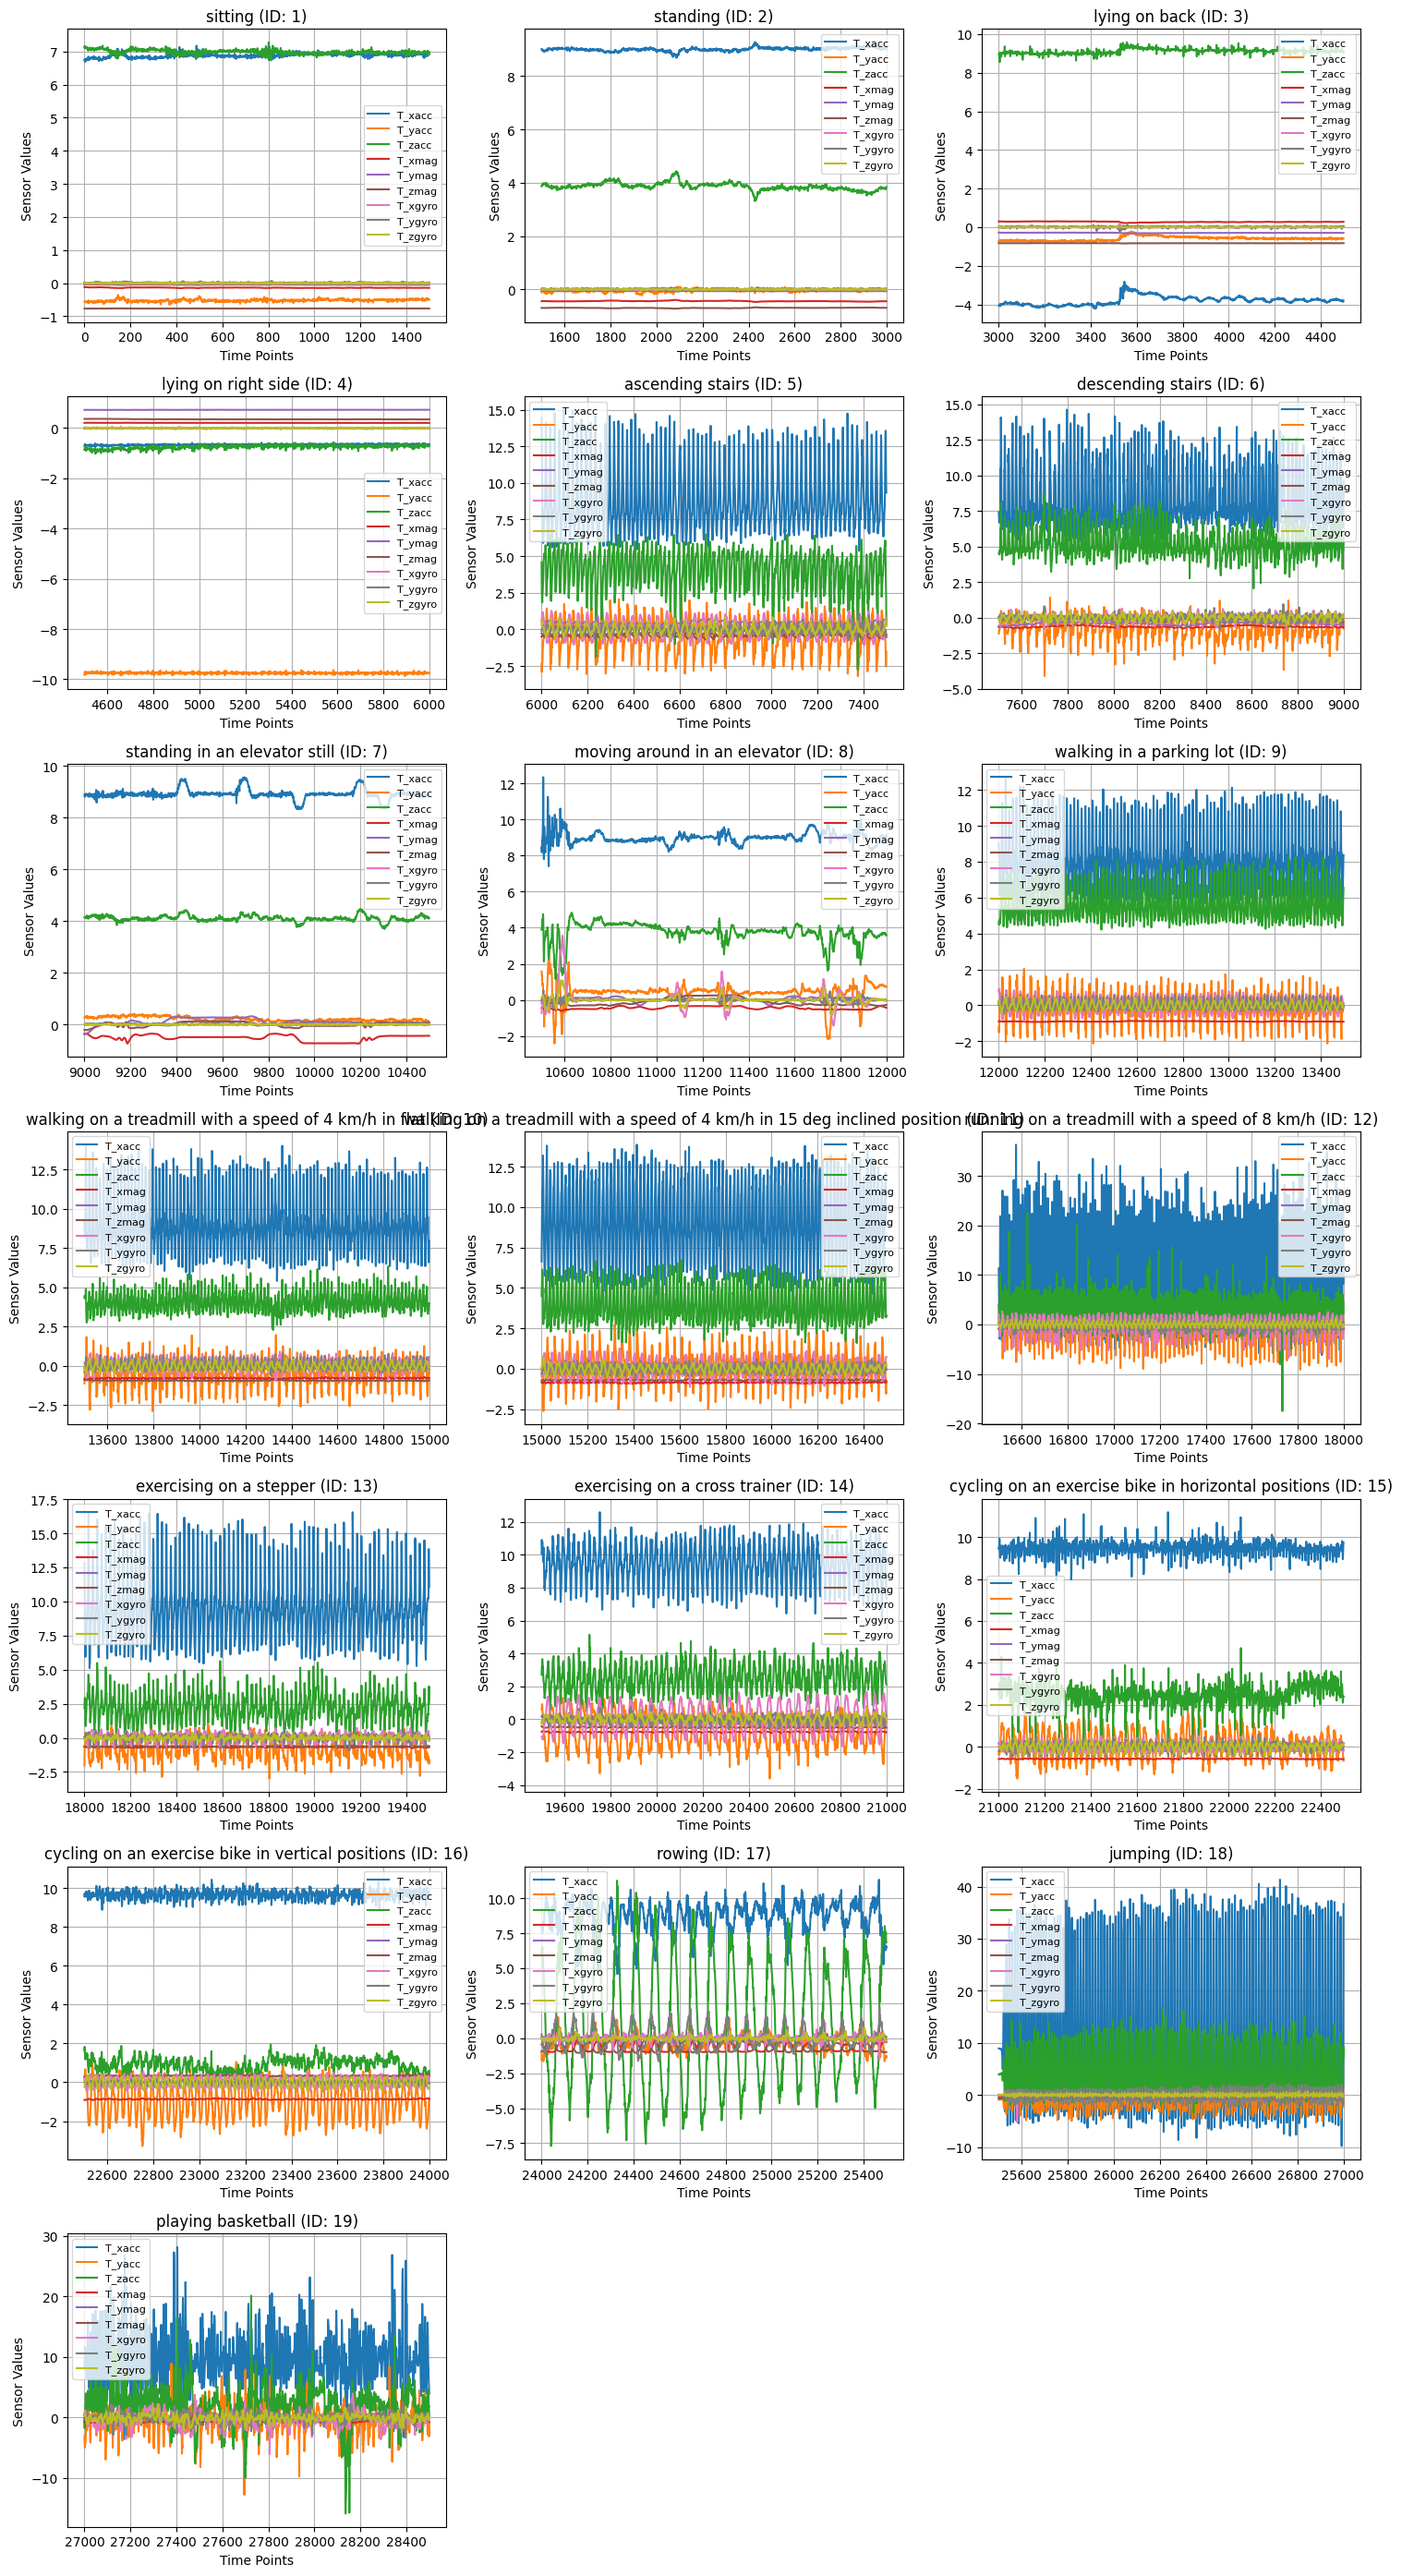

In [286]:
def plot_sensors_for_activities_grid(data, sensNamesSub, actNames):
    """
    Plot sensor data for each activity in a grid layout (3 plots per row) with full activity names in titles.

    Args:
    - data: DataFrame with sensor values and activity labels.
    - sensNamesSub: List of selected sensor names.
    - actNames: List of full activity names.
    """
    activities = data['activity'].unique()
    n_activities = len(activities)
    
    # Create a grid: 3 plots per row
    n_cols = 3
    n_rows = (n_activities + n_cols - 1) // n_cols  # Calculate the required number of rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))  # Adjust figure size
    axes = axes.flatten()  # Flatten axes array for easier indexing
    
    for i, act in enumerate(activities):
        ax = axes[i]
        act_data = data[data['activity'] == act]  # Filter data for the activity
        
        for sensor in sensNamesSub:
            ax.plot(act_data[sensor], label=sensor)  # Plot raw sensor values
        
        ax.set_title(f"{actNames[int(act) - 1]} (ID: {int(act)})")  # Use full activity name
        ax.set_xlabel("Time Points")
        ax.set_ylabel("Sensor Values")
        ax.legend(fontsize=8)
        ax.grid(True)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


# Generate the dataset
data = generateDF(filedir, sensNames, sensors, patients, activities, slices)

# Plot sensor data for all activities in a grid
plot_sensors_for_activities_grid(data, sensNamesSub, actNames)


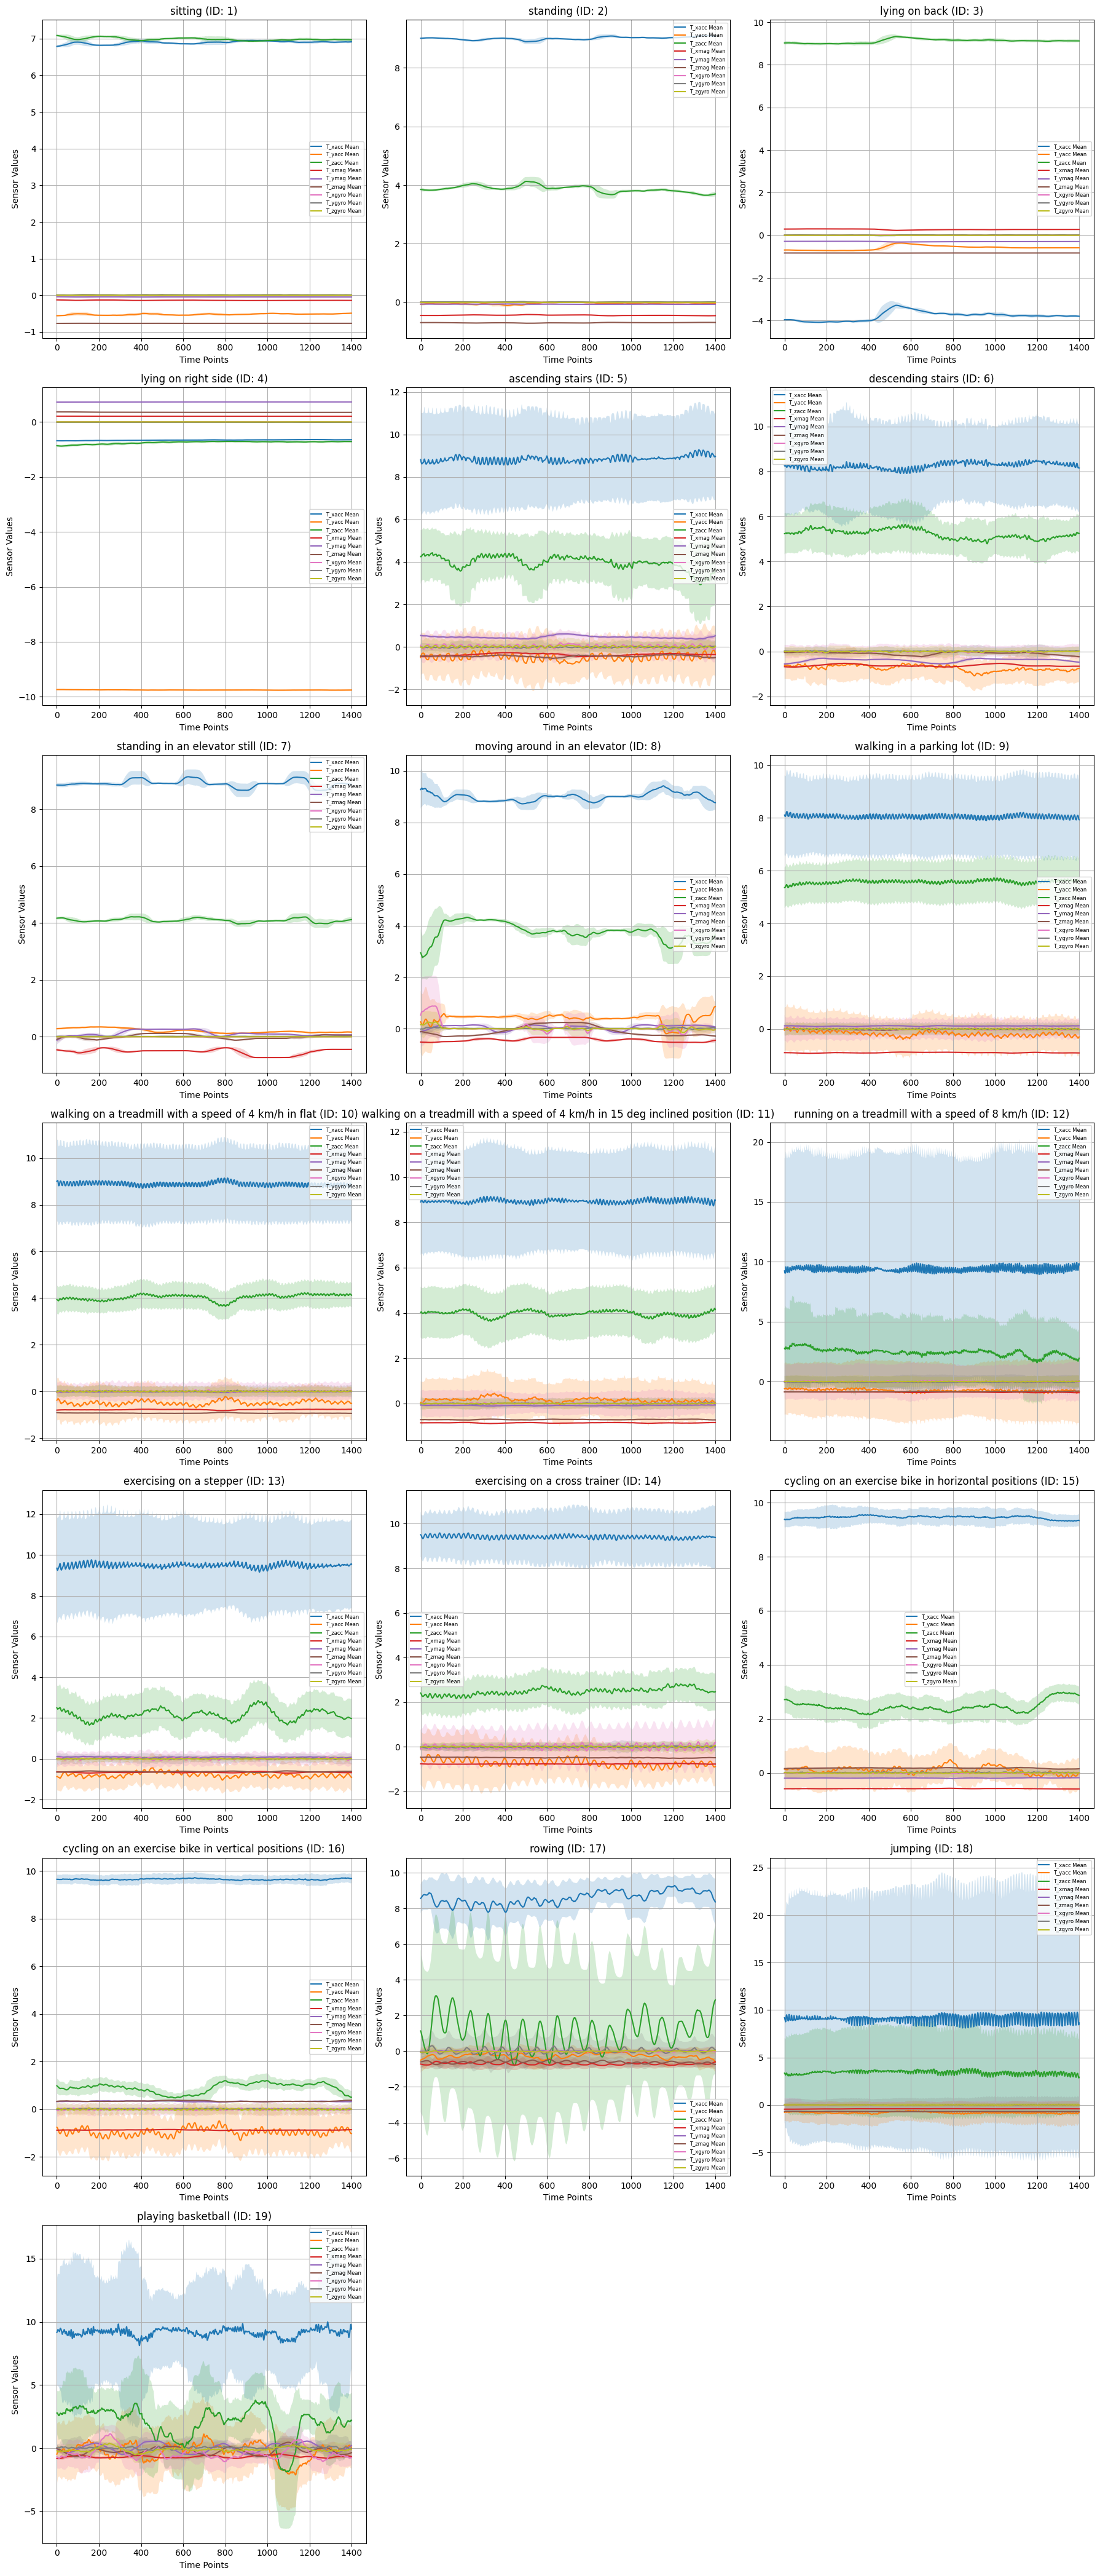

In [287]:
import matplotlib.pyplot as plt

# Create a dictionary to store filtered data for all activities
filtered_data_dict = {}

# Process data for each activity and store it
for act in activities:
    # Filter data for the current activity
    act_data = data[data['activity'] == act]
    
    # Check if act_data is empty
    if act_data.empty:
        print(f"No data for activity {act}. Skipping.")
        continue
    
    # Apply genFeatures to generate mean and std features
    window_size = 100  # Define the window size
    filtered_data = genFeatures(act_data, window_size)
    
    # Store the filtered data in the dictionary
    filtered_data_dict[act] = filtered_data

# Create a grid for plotting: 3 plots per row
n_activities = len(filtered_data_dict)
n_cols = 3
n_rows = (n_activities + n_cols - 1) // n_cols  # Calculate required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten()  # Flatten axes for easier indexing

# Plot each activity
for i, (act, filtered_data) in enumerate(filtered_data_dict.items()):
    ax = axes[i]
    
    # Plot filtered data for each sensor
    for sensor in sensNamesSub:
        ax.plot(filtered_data[f"{sensor}_mean"], label=f"{sensor} Mean")
        ax.fill_between(
            range(len(filtered_data)),
            filtered_data[f"{sensor}_mean"] - filtered_data[f"{sensor}_std"],
            filtered_data[f"{sensor}_mean"] + filtered_data[f"{sensor}_std"],
            alpha=0.2
        )
    ax.set_title(f"{actNames[act - 1]} (ID: {act})")
    ax.set_xlabel("Time Points")
    ax.set_ylabel("Sensor Values")
    ax.legend(fontsize=6)
    ax.grid(True)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Cluster Centroids [4]

In [288]:
activities

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Number of used sensors: 9


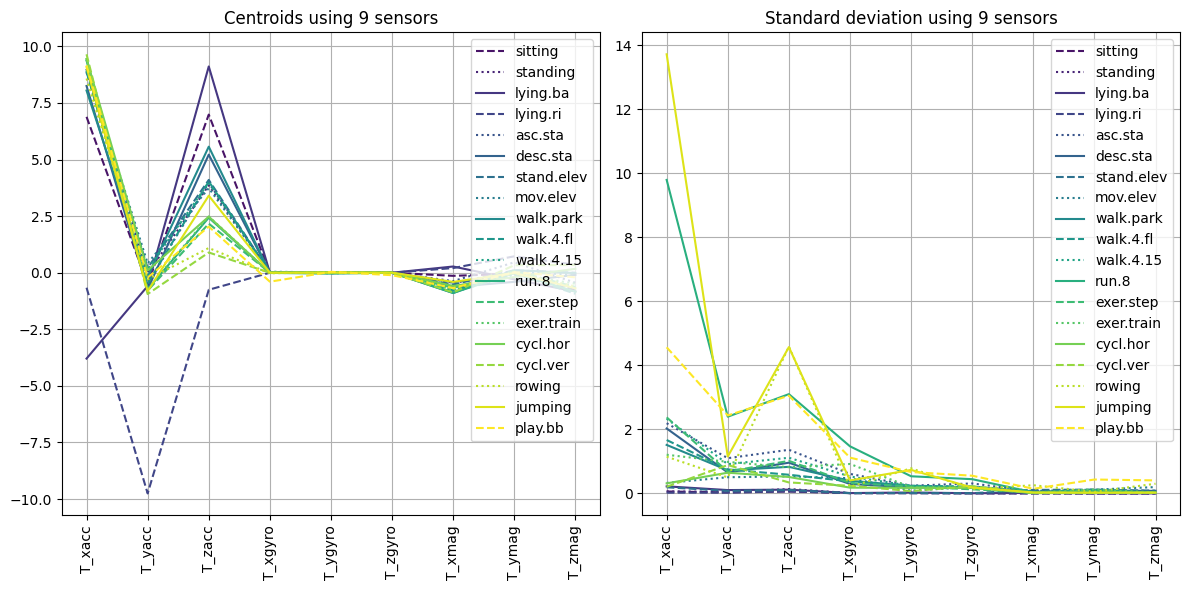

In [289]:
# Import required modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Define line styles
linestyles = ['-', '--', ':']  # Solid, dashed, dotted

# Plot centroids and standard deviation of sensor values
print('Number of used sensors:', len(sensors))

# Initialize arrays for centroids and standard deviations
centroids = np.zeros((NAc, len(sensors)))  # Centroids for all activities
std_points = np.zeros((NAc, len(sensors)))  # Variance in cluster for each sensor

plt.figure(figsize=(12, 6))

# Loop through all activities
for i in range(1, NAc + 1):
    activities = [i]  # Current activity
    x = generateDF(filedir, sensNames, sensors, patients, activities, slices)  # Generate data
    x = x.drop(columns=['activity'])  # Remove activity column for centroid calculation
    
    # Calculate centroids and standard deviation
    centroids[i - 1, :] = x.mean().values
    std_points[i - 1, :] = np.sqrt(x.var().values)
    
    # Plot centroids
    plt.subplot(1, 2, 1)
    lines = plt.plot(centroids[i - 1, :], label=actNamesShort[i - 1])
    lines[0].set_color(cm.viridis(i / NAc))  # Use 'viridis' colormap
    lines[0].set_linestyle(linestyles[i % 3])
    
    # Plot standard deviation
    plt.subplot(1, 2, 2)
    lines = plt.plot(std_points[i - 1, :], label=actNamesShort[i - 1])
    lines[0].set_color(cm.viridis(i / NAc))  # Use 'viridis' colormap
    lines[0].set_linestyle(linestyles[i % 3])

# Finalize plots for centroids
plt.subplot(1, 2, 1)
plt.legend(loc='upper right')
plt.grid()
plt.title(f'Centroids using {len(sensors)} sensors')
plt.xticks(np.arange(x.shape[1]), list(x.columns), rotation=90)

# Finalize plots for standard deviation
plt.subplot(1, 2, 2)
plt.legend(loc='upper right')
plt.grid()
plt.title(f'Standard deviation using {len(sensors)} sensors')
plt.xticks(np.arange(x.shape[1]), list(x.columns), rotation=90)

plt.tight_layout()
plt.show()


#### Centroids and standard deviation for all activities Filtered data

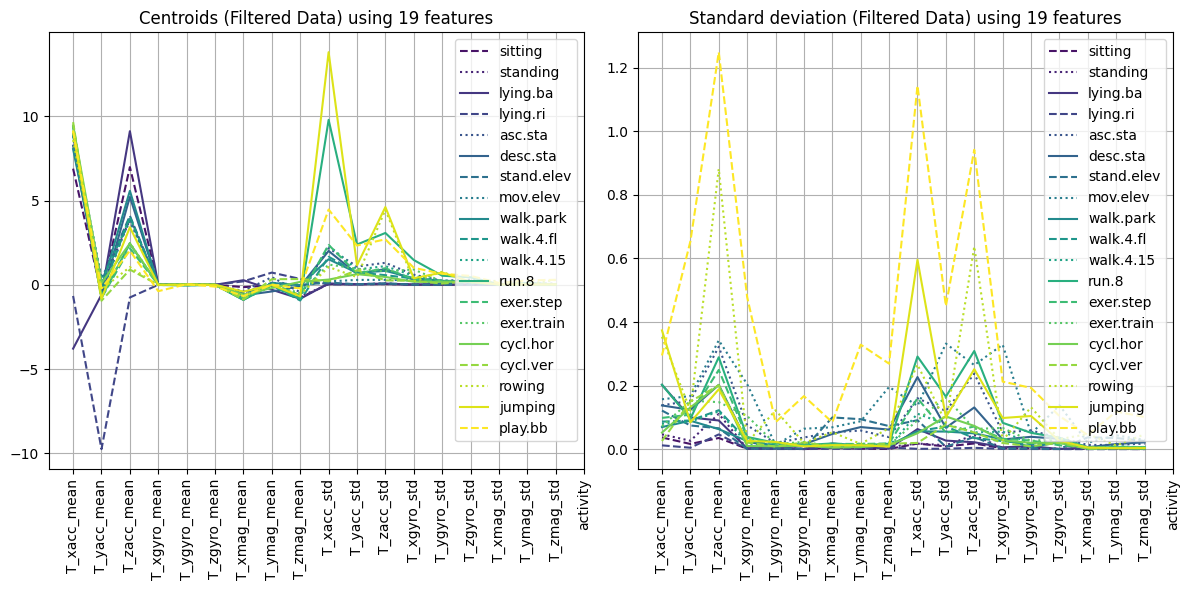

In [290]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

# Define line styles
linestyles = ['-', '--', ':']  # Solid, dashed, dotted

# Dynamically determine the complete list of features
all_features = list(next(iter(filtered_data_dict.values())).columns)
n_features = len(all_features)

# Initialize arrays for filtered data
centroids_filtered = np.zeros((len(filtered_data_dict), n_features))  # Match the shape of filtered data
std_points_filtered = np.zeros((len(filtered_data_dict), n_features))  # Standard deviations for filtered data

plt.figure(figsize=(12, 6))

# Loop through all activities and ensure consistent features
for i, (act, filtered_data) in enumerate(filtered_data_dict.items()):
    # Drop the activity column if present
    filtered_data = filtered_data.drop(columns=['activity'], errors='ignore')

    # Align features: Add missing features with NaN values
    for feature in all_features:
        if feature not in filtered_data.columns:
            filtered_data[feature] = np.nan

    # Ensure the feature order is consistent
    filtered_data = filtered_data[all_features]

    # Calculate centroids and standard deviations
    centroids_filtered[i, :] = filtered_data.mean().values
    std_points_filtered[i, :] = np.sqrt(filtered_data.var().values)

    # Plot centroids
    plt.subplot(1, 2, 1)
    lines = plt.plot(centroids_filtered[i, :], label=actNamesShort[act - 1])
    lines[0].set_color(cm.viridis(act / NAc))  # Use 'viridis' colormap
    lines[0].set_linestyle(linestyles[act % 3])

    # Plot standard deviations
    plt.subplot(1, 2, 2)
    lines = plt.plot(std_points_filtered[i, :], label=actNamesShort[act - 1])
    lines[0].set_color(cm.viridis(act / NAc))  # Use 'viridis' colormap
    lines[0].set_linestyle(linestyles[act % 3])

# Finalize plots for centroids
plt.subplot(1, 2, 1)
plt.legend(loc='upper right')
plt.grid()
plt.title(f'Centroids (Filtered Data) using {n_features} features')
plt.xticks(np.arange(len(all_features)), all_features, rotation=90)

# Finalize plots for standard deviations
plt.subplot(1, 2, 2)
plt.legend(loc='upper right')
plt.grid()
plt.title(f'Standard deviation (Filtered Data) using {n_features} features')
plt.xticks(np.arange(len(all_features)), all_features, rotation=90)

plt.tight_layout()
plt.show()


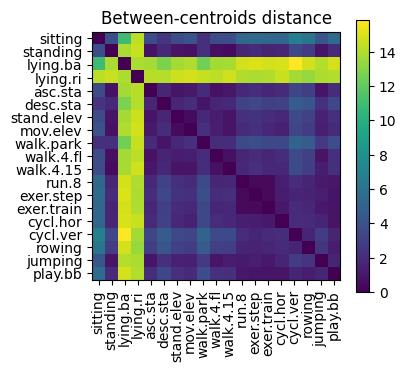

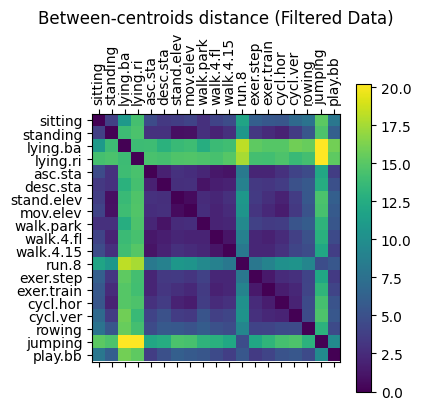

In [291]:
#%% Between-centroids distance
# Initialize distance matrix
d = np.zeros((NAc, NAc))
d_filtered = np.zeros((NAc, NAc))
# Calculate distances between centroids
for i in range(NAc):
    for j in range(NAc):
        d[i, j] = np.linalg.norm(centroids[i] - centroids[j])  # Euclidean distance

# Visualize the distance matrix if plotting is enabled
plt.figure(figsize=(4, 4))
plt.matshow(d, fignum=0)  # Display the matrix as an image
plt.gca().xaxis.tick_bottom()  # Ensure x-axis ticks are on the bottom
plt.colorbar()  # Add colorbar for scale
plt.xticks(np.arange(NAc), actNamesShort, rotation=90)  # Set x-axis labels
plt.yticks(np.arange(NAc), actNamesShort)  # Set y-axis labels
plt.subplots_adjust(bottom=0.2)  # Adjust subplot spacing
plt.title('Between-centroids distance')  # Add title
plt.show()

# Replace NaN with zeros
centroids_filtered = np.nan_to_num(centroids_filtered, nan=0.0)

# Calculate distances
d = np.zeros((NAc, NAc))
for i in range(NAc):
    for j in range(NAc):
        d_filtered[i, j] = np.linalg.norm(centroids_filtered[i] - centroids_filtered[j])  # Euclidean distance

# Visualize the distance matrix
plt.figure(figsize=(4, 4))
plt.matshow(d_filtered, fignum=0)
plt.colorbar()
plt.xticks(np.arange(NAc), actNamesShort, rotation=90)
plt.yticks(np.arange(NAc), actNamesShort)
plt.title("Between-centroids distance (Filtered Data)")
plt.show()





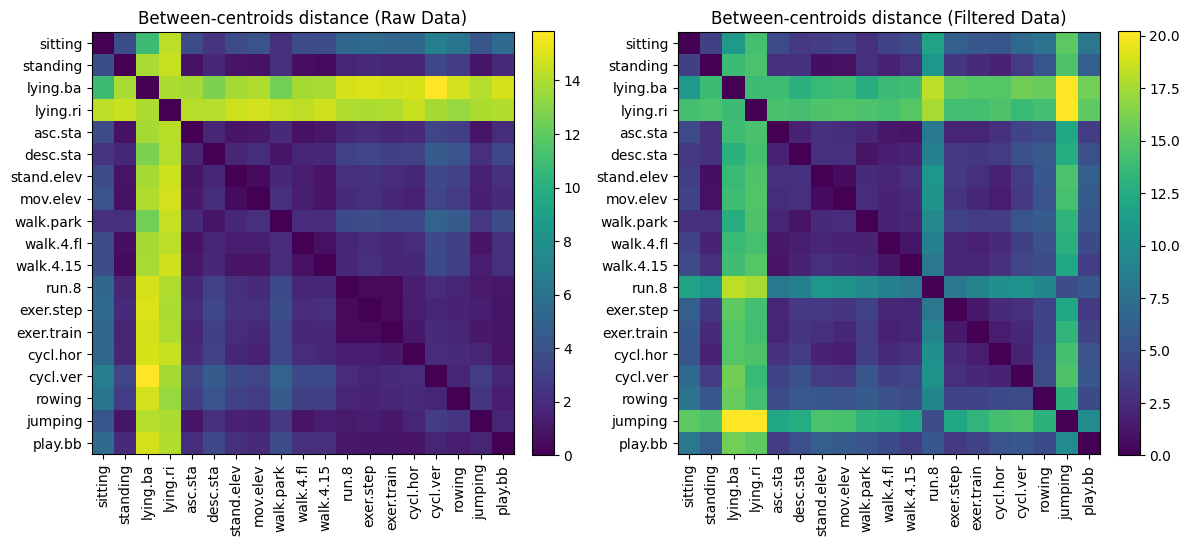

In [292]:
#%% Between-centroids distance: Side-by-side plots
# Initialize distance matrix for raw data
d_raw = np.zeros((NAc, NAc))

# Calculate distances for raw centroids
for i in range(NAc):
    for j in range(NAc):
        d_raw[i, j] = np.linalg.norm(centroids[i] - centroids[j])  # Euclidean distance

# Replace NaN with zeros in filtered centroids
centroids_filtered = np.nan_to_num(centroids_filtered, nan=0.0)

# Initialize distance matrix for filtered data
d_filtered = np.zeros((NAc, NAc))

# Calculate distances for filtered centroids
for i in range(NAc):
    for j in range(NAc):
        d_filtered[i, j] = np.linalg.norm(centroids_filtered[i] - centroids_filtered[j])  # Euclidean distance

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot raw data distance matrix
im1 = axes[0].matshow(d_raw)
axes[0].xaxis.tick_bottom()  # Ensure x-axis ticks are on the bottom
axes[0].set_xticks(np.arange(NAc))
axes[0].set_xticklabels(actNamesShort, rotation=90)
axes[0].set_yticks(np.arange(NAc))
axes[0].set_yticklabels(actNamesShort)
axes[0].set_title("Between-centroids distance (Raw Data)")
axes[0].grid(False)
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# Plot filtered data distance matrix
im2 = axes[1].matshow(d_filtered)
axes[1].xaxis.tick_bottom()  # Ensure x-axis ticks are on the bottom
axes[1].set_xticks(np.arange(NAc))
axes[1].set_xticklabels(actNamesShort, rotation=90)
axes[1].set_yticks(np.arange(NAc))
axes[1].set_yticklabels(actNamesShort)
axes[1].set_title("Between-centroids distance (Filtered Data)")
axes[1].grid(False)
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [293]:
# std_points_filtered[: , 0:18]
# std_points

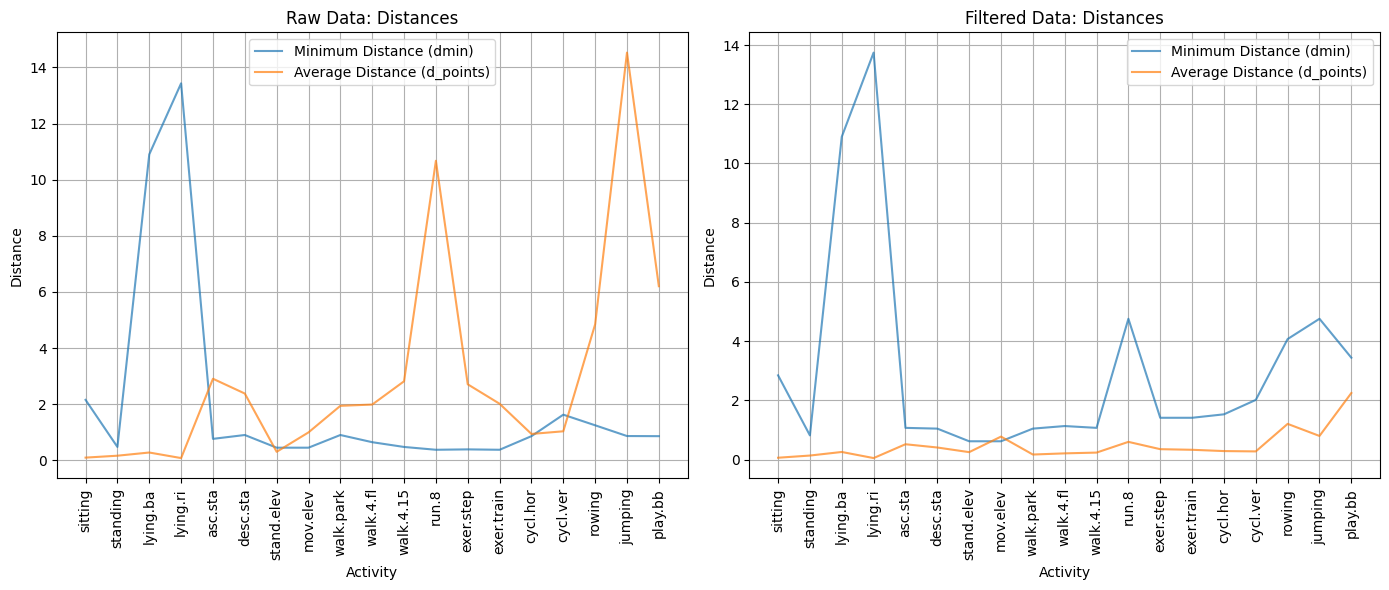

In [294]:
import matplotlib.pyplot as plt
import numpy as np

#%% Calculate distances for raw data
# Remove zeros on the diagonal for raw data
dd_raw = d_raw + np.eye(NAc) * 1e6  # Add a large value to the diagonal
dmin_raw = dd_raw.min(axis=0)  # Minimum distance for each centroid

# Average distance of points from centroids (raw data)
d2_raw = np.sum(std_points ** 2, axis=1)  # Sum of variances (std squared)
d_points_raw = np.sqrt(d2_raw)  # Square root to get mean distance

#%% Calculate distances for filtered data
# Remove zeros on the diagonal for filtered data
dd_filtered = d_filtered + np.eye(NAc) * 1e6  # Add a large value to the diagonal
dmin_filtered = dd_filtered.min(axis=0)  # Minimum distance for each centroid

# Average distance of points from centroids (filtered data)
d2_filtered = np.sum(std_points_filtered[: , 0:18] ** 2, axis=1)  # Sum of variances (std squared)
d_points_filtered = np.sqrt(d2_filtered)  # Square root to get mean distance

#%% Plot raw and filtered data distances
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw data plot
axes[0].plot(range(1, NAc + 1), dmin_raw, label="Minimum Distance (dmin)", alpha=0.7)
axes[0].plot(range(1, NAc + 1), d_points_raw, label="Average Distance (d_points)", alpha=0.7)
axes[0].set_title("Raw Data: Distances")
axes[0].set_xlabel("Activity")
axes[0].set_ylabel("Distance")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(range(1, NAc + 1))
axes[0].set_xticklabels(actNamesShort, rotation=90)

# Filtered data plot
axes[1].plot(range(1, NAc + 1), dmin_filtered, label="Minimum Distance (dmin)", alpha=0.7)
axes[1].plot(range(1, NAc + 1), d_points_filtered, label="Average Distance (d_points)", alpha=0.7)
axes[1].set_title("Filtered Data: Distances")
axes[1].set_xlabel("Activity")
axes[1].set_ylabel("Distance")
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(range(1, NAc + 1))
axes[1].set_xticklabels(actNamesShort, rotation=90)

# Adjust layout and show
plt.tight_layout()
plt.show()


### K-Means

In [295]:
import numpy as np
from sklearn.cluster import KMeans

#%% Generate training and test datasets
# Define slices for training and testing
slicesTrain = list(range(1, Nslices + 1))  # Training slices
slicesTest = list(range(Nslices + 1, NtotSlices + 1))  # Testing slices

# Initialize empty arrays for data and labels
dataTrain = np.empty((0, len(sensors) * 2), float)
dataTest = np.empty((0, len(sensors) * 2), float)
labelTrain = np.empty((0,), float)
labelTest = np.empty((0,), float)

memory = 100  # Memory size for feature generation #TODO 2 this increases the accuracy over .8
# Loop through all activities
for i in range(1, NAc + 1):
    activ = [i]
    
    # Generate training data
    x_train = generateDF(filedir, sensNamesSub, sensors, patients, activ, slicesTrain)
    x_train = genFeatures(x_train, memory)
    labels_train = x_train['activity'].values
    x_train = x_train.drop(columns=['activity'])
    dataTrain = np.vstack((dataTrain, x_train.values))
    labelTrain = np.hstack((labelTrain, labels_train))
    
    # Generate test data
    x_test = generateDF(filedir, sensNamesSub, sensors, patients, activ, slicesTest)
    x_test = genFeatures(x_test, memory)
    labels_test = x_test['activity'].values
    x_test = x_test.drop(columns=['activity'])
    dataTest = np.vstack((dataTest, x_test.values))
    labelTest = np.hstack((labelTest, labels_test))

#%% Apply K-Means clustering
# Determine the number of clusters (unique activities)
labsTrue = np.unique(labelTrain)
Nclu = len(labsTrue)

# Initialize and fit K-Means
kmeans = KMeans(
    n_clusters=Nclu, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=1
)
kmeans.fit(dataTrain)

# Get cluster labels for training data
labCluTrain = kmeans.labels_
labsCluTrain = np.unique(labCluTrain)

# Predict cluster labels for test data
labCluTest = kmeans.predict(dataTest)

#%% Print results
print(f"Number of clusters: {Nclu}")
print(f"Training labels (unique): {labsCluTrain}")
print(f"Cluster labels for training data: {labCluTrain}")
print(f"Cluster labels for test data: {labCluTest}")


Number of clusters: 19
Training labels (unique): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Cluster labels for training data: [ 7  7  7 ... 10 10 10]
Cluster labels for test data: [ 7  7  7 ... 14 14 14]


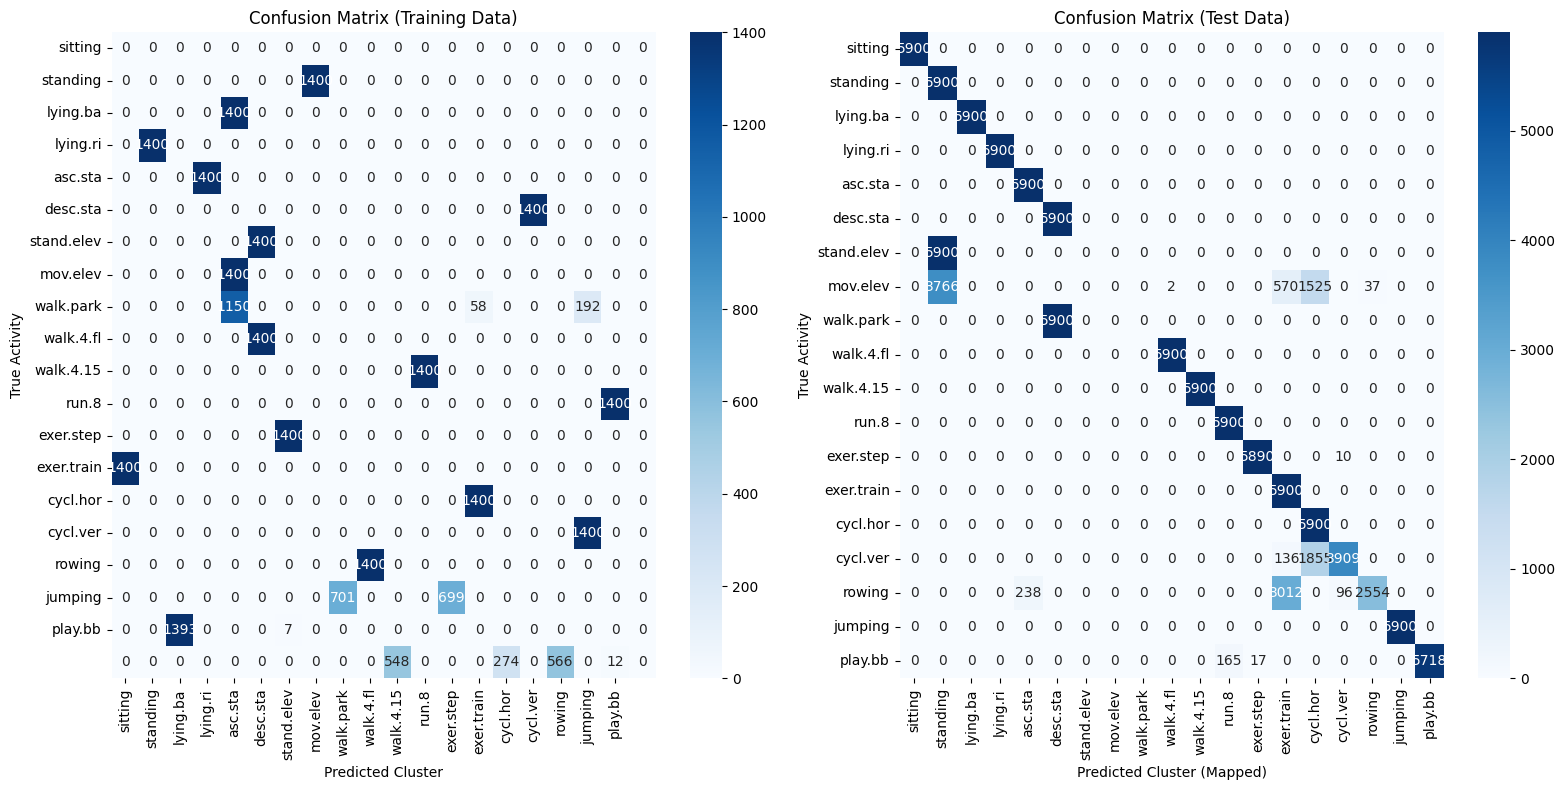

In [296]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#%% Match cluster labels with true labels
# Generate a confusion matrix
conf_matrix = confusion_matrix(labelTrain, labCluTrain)

# Find the best label mapping
best_mapping = np.argmax(conf_matrix, axis=0)

# Apply label mapping
mapped_labels_train = np.array([best_mapping[cl] for cl in labCluTrain])
mapped_labels_test = np.array([best_mapping[cl] for cl in labCluTest])

# Confusion matrix for test data
conf_matrix_test = confusion_matrix(labelTest, mapped_labels_test)

#%% Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Training dataset confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=actNamesShort, yticklabels=actNamesShort, ax=axes[0])
axes[0].set_title("Confusion Matrix (Training Data)")
axes[0].set_xlabel("Predicted Cluster")
axes[0].set_ylabel("True Activity")

# Test dataset confusion matrix
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=actNamesShort, yticklabels=actNamesShort, ax=axes[1])
axes[1].set_title("Confusion Matrix (Test Data)")
axes[1].set_xlabel("Predicted Cluster (Mapped)")
axes[1].set_ylabel("True Activity")

# Adjust layout and show
plt.tight_layout()
plt.show()


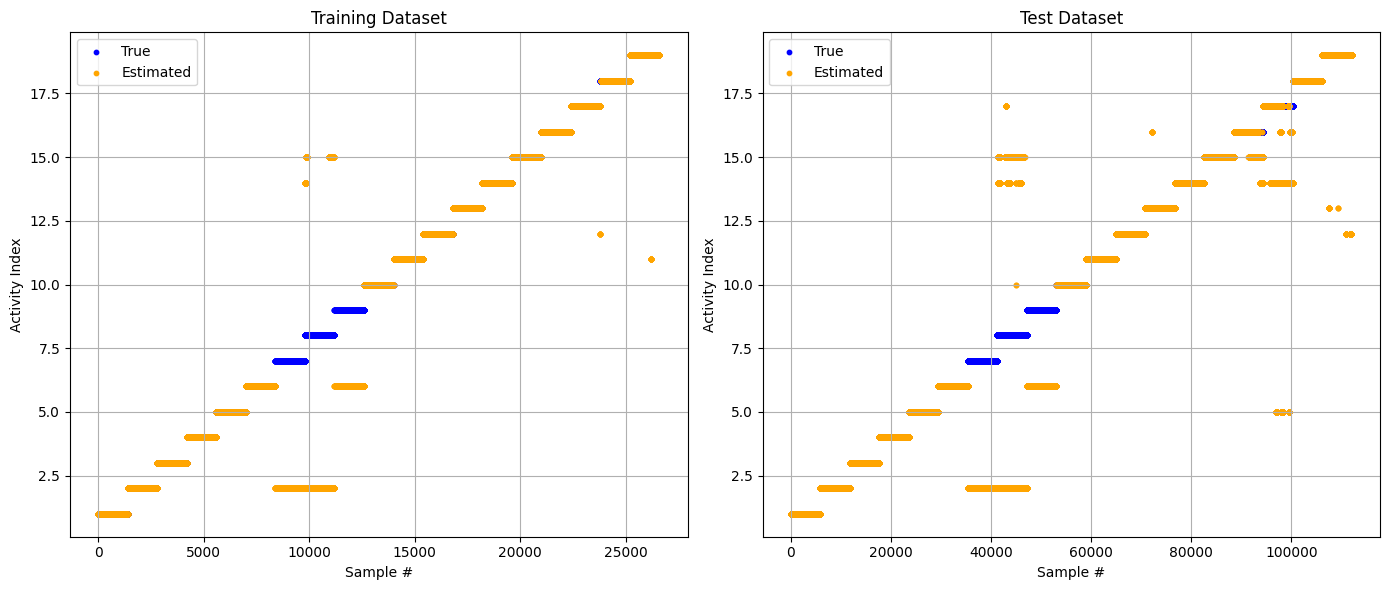

In [297]:
import matplotlib.pyplot as plt

#%% Scatterplot for training and test datasets
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training dataset scatterplot
axes[0].scatter(range(len(labelTrain)), labelTrain, color='blue', s=10, label='True')  # True labels
axes[0].scatter(range(len(labCluTrain)), mapped_labels_train, color='orange', s=10, label='Estimated')  # Predicted labels
axes[0].set_title("Training Dataset")
axes[0].set_xlabel("Sample #")
axes[0].set_ylabel("Activity Index")
axes[0].legend()
axes[0].grid(True)

# Test dataset scatterplot
axes[1].scatter(range(len(labelTest)), labelTest, color='blue', s=10, label='True')  # True labels
axes[1].scatter(range(len(labCluTest)), mapped_labels_test, color='orange', s=10, label='Estimated')  # Predicted labels
axes[1].set_title("Test Dataset")
axes[1].set_xlabel("Sample #")
axes[1].set_ylabel("Activity Index")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Generate a Confusion Matrix:

-A confusion matrix helps visualize the correspondence between the true activity labels and the K-Means cluster labels.
Map Clusters to Activities:

-Match each cluster index to the most likely activity index by finding the highest value in each column of the confusion matrix. This process aligns the cluster labels with the activities.
Evaluate Performance:

-Use metrics like accuracy (percentage of correctly aligned samples) or visual tools like confusion matrices or scatterplots to verify alignment.
Visualize Results:

-Plot aligned results using:
Confusion Matrices: Show the mapping of clusters to activities.
Scatterplots: Compare true and predicted activity labels for individual samples.

In [298]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for training and test datasets
accuracy_train = accuracy_score(labelTrain, mapped_labels_train)
accuracy_test = accuracy_score(labelTest, mapped_labels_test)

print(f"Training Accuracy: {accuracy_train:.2f}")
print(f"Test Accuracy: {accuracy_test:.2f}")


Training Accuracy: 0.84
Test Accuracy: 0.79


## To Do 1

In [299]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrix for training data
conf_matrix = confusion_matrix(labelTrain, labCluTrain)

# Map each cluster to the most likely activity
best_mapping = np.argmax(conf_matrix, axis=0)

# Apply mapping to align cluster labels with true activity labels
mapped_labels_train = np.array([best_mapping[cl] for cl in labCluTrain])
mapped_labels_test = np.array([best_mapping[cl] for cl in labCluTest])


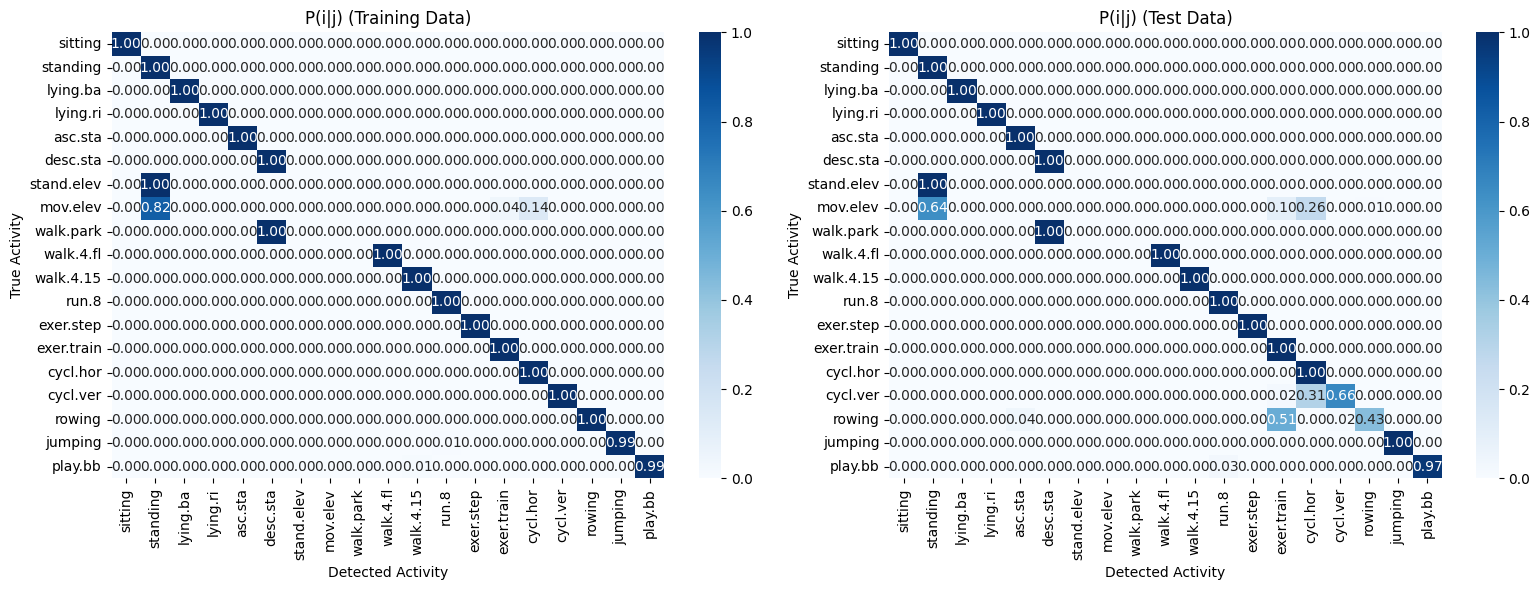

In [300]:
# Training conditional probabilities
conf_matrix_train = confusion_matrix(labelTrain, mapped_labels_train, normalize='true')

# Test conditional probabilities
conf_matrix_test = confusion_matrix(labelTest, mapped_labels_test, normalize='true')

# Plot the matrices
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training dataset
sns.heatmap(conf_matrix_train, annot=True, fmt=".2f", cmap="Blues", xticklabels=actNamesShort, yticklabels=actNamesShort, ax=axes[0])
axes[0].set_title("P(i|j) (Training Data)")
axes[0].set_xlabel("Detected Activity")
axes[0].set_ylabel("True Activity")

# Test dataset
sns.heatmap(conf_matrix_test, annot=True, fmt=".2f", cmap="Blues", xticklabels=actNamesShort, yticklabels=actNamesShort, ax=axes[1])
axes[1].set_title("P(i|j) (Test Data)")
axes[1].set_xlabel("Detected Activity")
axes[1].set_ylabel("True Activity")

plt.tight_layout()
plt.show()


In [301]:
# Calculate accuracy for training data
accuracy_train = np.trace(conf_matrix_train) / len(actNamesShort)  # Trace gives P(i|i) sum

# Calculate accuracy for test data
accuracy_test = np.trace(conf_matrix_test) / len(actNamesShort)

print(f"Training Accuracy: {accuracy_train:.2f}")
print(f"Test Accuracy: {accuracy_test:.2f}")


Training Accuracy: 0.84
Test Accuracy: 0.79


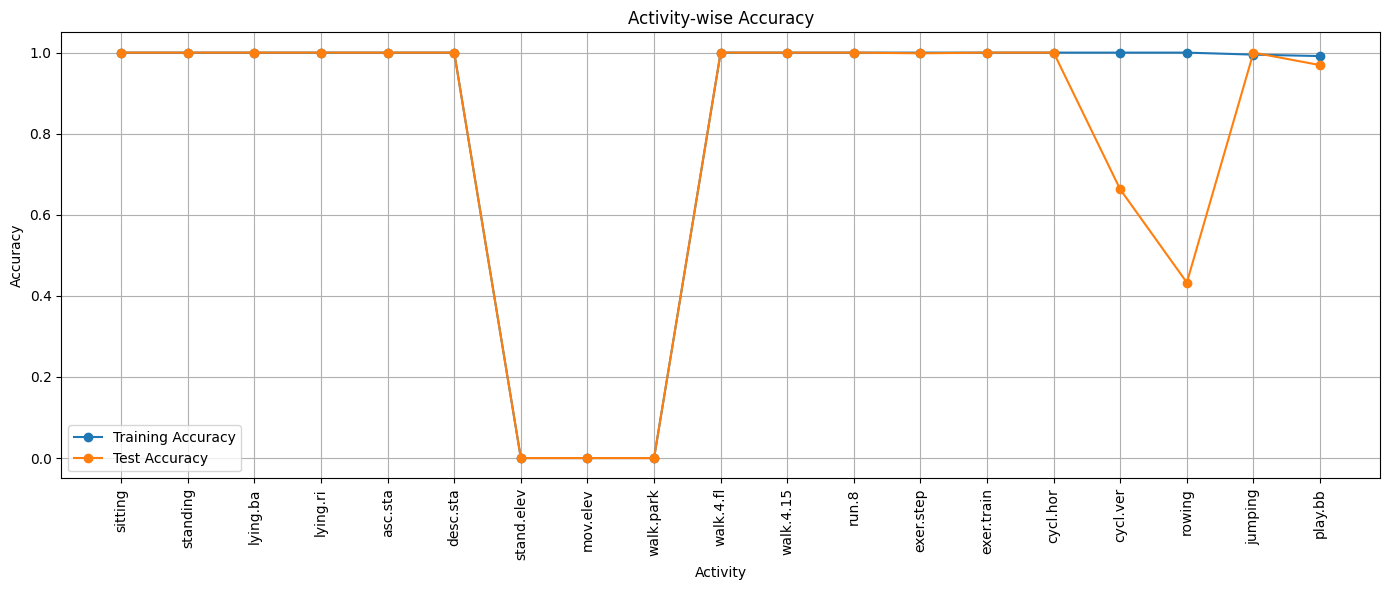

Most confused activities in training data: stand.elev and standing
Most confused activities in test data: stand.elev and standing


In [302]:
# Accuracy for each activity (diagonal of P(i|j))
activity_accuracy_train = np.diag(conf_matrix_train)
activity_accuracy_test = np.diag(conf_matrix_test)

# Plot activity-wise accuracy
plt.figure(figsize=(14, 6))
plt.plot(range(1, NAc + 1), activity_accuracy_train, label="Training Accuracy", marker='o')
plt.plot(range(1, NAc + 1), activity_accuracy_test, label="Test Accuracy", marker='o')
plt.xticks(range(1, NAc + 1), actNamesShort, rotation=90)
plt.xlabel("Activity")
plt.ylabel("Accuracy")
plt.title("Activity-wise Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the two activities that are most confused
# Look for the maximum off-diagonal value in the confusion matrices
most_confused_train = np.unravel_index(np.argmax(conf_matrix_train - np.diag(np.diag(conf_matrix_train))), conf_matrix_train.shape)
most_confused_test = np.unravel_index(np.argmax(conf_matrix_test - np.diag(np.diag(conf_matrix_test))), conf_matrix_test.shape)

print(f"Most confused activities in training data: {actNamesShort[most_confused_train[0]]} and {actNamesShort[most_confused_train[1]]}")
print(f"Most confused activities in test data: {actNamesShort[most_confused_test[0]]} and {actNamesShort[most_confused_test[1]]}")


## To Do 2